# **<span style="color:green"><b>VisionMath Notebook</b></span>**

VisionMath is a personal project for the Computer Vision subject at UMA, created by Adrián Torremocha Doblas.
The main purpose of the program is **the resolution of simple mathematical expression from handwritten images.**

This version of the project only supports the basic operations: addition, subtraction, multiplication and division of integer numbers.

This notebook will be a brief overview of the pipeline of the project, explaining the behavior of some of the functions I defined. If you want to dive deep into the code, remember that you can find more details in the project files.

In [10]:
# SOURCE CODE
import clasiffication
import main_vm

# SOME REQUIRED IMPORTS
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
from scipy import signal

matplotlib.rcParams['figure.figsize'] = (12.0, 5.0)

# CHANGE IMAGES PATH TO USE YOUR OWN IMAGES OR ADD THEM TO THE FOLDER
images_path = "images/testingImages/"

# **<span style="color:blue"><b><i>1.- Image Processing</i></b></span>**

As expected, Image Processing is the first step in the whole process. Our goal is the binarization of the image through the use of quick and efficient algorithms, and thus, It will be necessary to apply different techniques that `OpenCV` provides.

![Image](images/notebookImages/img_1.png)

But first of all, We will start by plotting the image We are going to work with:

> On the *images/testingImages* folder there are some images that I used to test the program. The images named as "easy", "hard" and "medium" where just meant to be used for testing the model, whereas the "testX" were taken to test the whole execution.

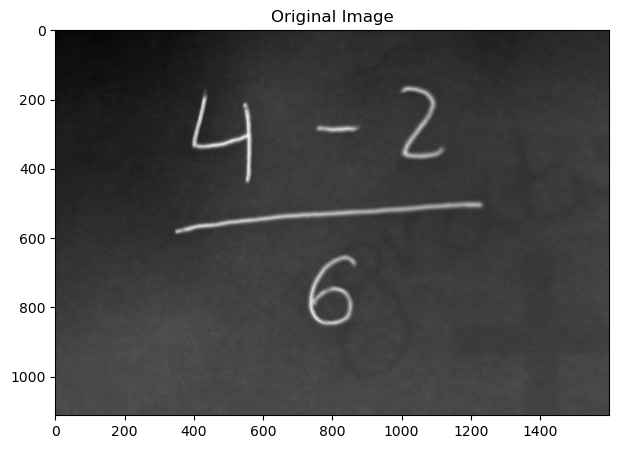

In [2]:
image = cv2.imread( images_path + "test2.jpeg", -1)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Invert intensity values
image = cv2.bitwise_not(image)

plt.title("Original Image")
plt.imshow(image, cmap='grey')

## Gaussian Filter

The first main algorithm is the iconic Gaussian Filter, It is really useful because It can help us erase some of the noise we could find in the image.

The parameters that determine the gaussian filter filter are the Kernel size and the sigma. In this case We will use values of 4 and 1, respectively.

[]

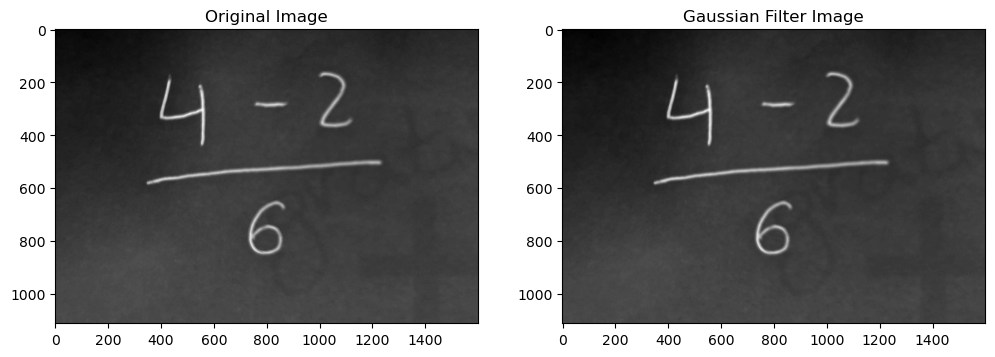

In [3]:
# The algorithm I have used is the one provided in the corresponding notebook
gauss_image = main_vm.gaussian_filter(image,w_kernel= 4,sigma= 1)

plt.subplot(121)
plt.title("Original Image")
plt.imshow(image, cmap='grey')

plt.subplot(122)
plt.title("Gaussian Filter Image")
plt.imshow(gauss_image, cmap='grey')

plt.plot()

Depending on the quality and conditions of the image, the Gaussian Filter can be more or less crucial. In this particular case, the image was taken with a good enough lighting. Therefore, the differences might not be noticeable.

## CLAHE (Contrast Limited  Adaptive Histogram Equalization)

CLAHE is an image processing technique used to enhance the contrast of an image while preventing the amplification of noise. Unlike traditional histogram equalization methods that operate globally on an entire image, CLAHE divides the image into smaller regions called tiles and applies histogram equalization independently to each tile.

In grayscale, the numbers (**light tones**) will have a value **close to 255**, whereas the paper(**dark tones**) will have a value **approximate to 0**. In the ideal case of taking the image from digital resources like Paint, this technique would not be neccesary. However, images taken from real handwritten operations tend to vary on these values because of lighting conditions or the handwritting itself (your pen may be out of ink, resulting in 128 values)

The use of CLAHE will allow us to increase the intensity of numbers, making them easier to binarize.

[]

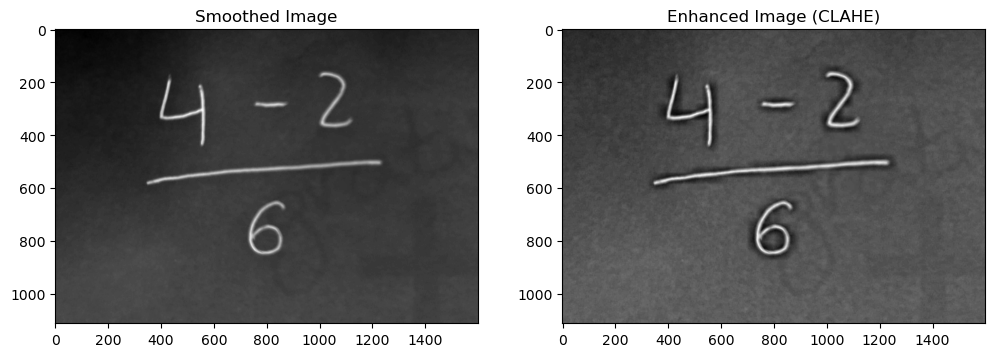

In [4]:
clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(48, 48))
enhanced_smoothed = clahe.apply(gauss_image)

plt.subplot(121)
plt.title("Smoothed Image")
plt.imshow(gauss_image, cmap='grey')

plt.subplot(122)
plt.title("Enhanced Image (CLAHE)")
plt.imshow(enhanced_smoothed, cmap='grey')

plt.plot()

Applying the histogram equalization locally fits better with my purpose rather than global methods. The reason behind this is that We want to increase the contrast on areas with really high intensity variations, not on the whole image. That is the reason why numbers are sorrounded by very dark tones in the CLAHE image.

Moreover, global methods tend to highlight unwanted details too:

![Image](images/notebookImages/img_2.png)

## LUT Binarization

Thanks to applying CLAHE in the previous step, We can now binarize the image with a simple LUT.

Numbers will have a value of approximately 255, so we can set the **threshold on 170** so that We do not lose details.

[]

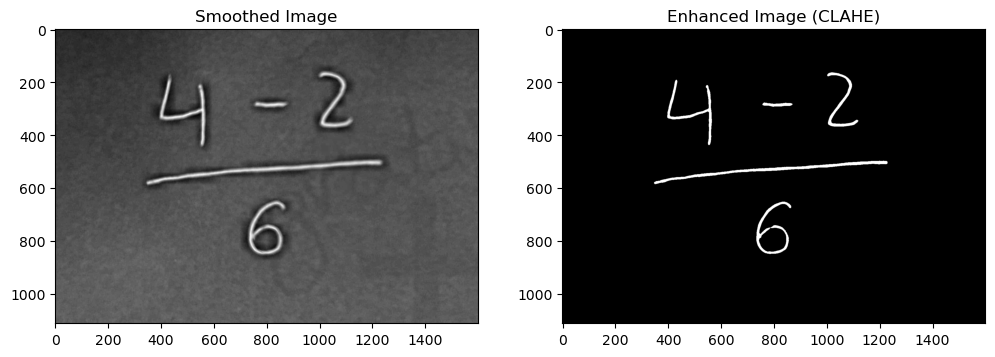

In [5]:
_, thresh_img = cv2.threshold(enhanced_smoothed, 170, 255, cv2.THRESH_BINARY)

plt.subplot(121)
plt.title("Smoothed Image")
plt.imshow(enhanced_smoothed, cmap='grey')

plt.subplot(122)
plt.title("Enhanced Image (CLAHE)")
plt.imshow(thresh_img, cmap='grey')

plt.plot()

We can see that the results are perfect. We have segmented the numbers and now we can continue with the next step of our pipeline.

# **<span style="color:blue"><b><i>2.- Extraction and treatment of contours</i></b></span>**

The main objective of this step is the detection of the contours and the **resizing to a specific size, 28x28.**

This will be necessary because We need to classify our contours with a prediction model, so the size of all contours must be the same.


## Contour extraction

Once We have binarized the image, We need to detect the contours. Thankfully, OpenCV provides differents methods to manage the contours of our image. The ones We are going to use are the next ones:

- **findContours()**: returns a list with the pixels that form each contour
- **boundingRect()**: provides us the origin (x,y), height (h) and width (w) of the contour

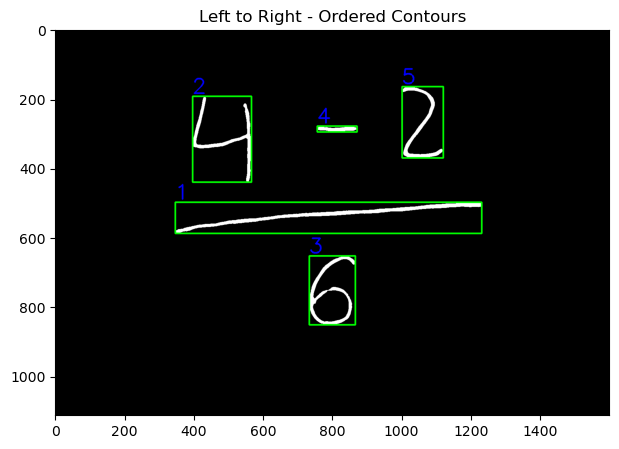

In [6]:
contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Create a list that contains the x, y, w, h of each contour
contours_ordered = [cv2.boundingRect(cnt) for cnt in contours]

# Clear out minor contours produced by noise
contours_ordered = main_vm.non_maxima_suppression_contours(contours_ordered)
contours_ordered = np.array(contours_ordered)

# print(contours_ordered)
# print("---------------------------------")

# Sort the contours from LEFT to RIGHT
contours_ordered = contours_ordered[np.argsort(contours_ordered[:, 0], kind='mergesort')]

plt.title("Left to Right - Ordered Contours")
plt.imshow(main_vm.draw_contours_lr_order(thresh_img, contours_ordered))
plt.show()

## Contour resizing

As We mentioned earlier, We need to resize the contours to 28x28. Nonetheless, We cannot use the cv2.resize method right away, because **we need to mantain the aspect ratio** of our contour. This image shows the results of not doing so:

![Image](images/notebookImages/img_3.png)

If We do nothing, the contour just shrinks to fit in the 28x28 image, resulting in a perfect square. Therefore, I have defined a function `fit_contour()` that calculates the new dimensions of the contour mantaining the aspect ratio (w/h) and makes sure the contour is centered in the resulting image.


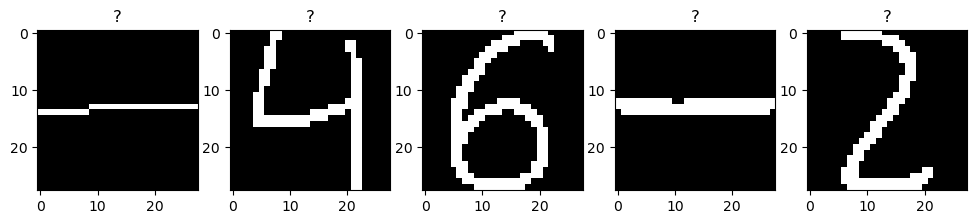

In [7]:
# Variables for plotting results
n_elements = len(contours_ordered)
n_cols_plot = int(n_elements / 5)
if n_elements % 5 != 0:
    n_cols_plot += 1

# This array contains the 28x28 images of all the contours in the image
data = np.zeros((clasiffication.rSize, clasiffication.cSize, len(contours_ordered)))
count = 0
for x, y, w, h in contours_ordered:
    # Generates de 28x28 from the 2D array(Bounding Rect of each contour)
    data[:, :, count] = clasiffication.fit_contour(thresh_img[y:y + h, x:x + w])
    
    plt.subplot(n_cols_plot, 5, count + 1)
    plt.title('?')
    plt.imshow(data[:, :, count], cmap='grey')
    count += 1

plt.show()

The title of the plotting is **'?'** because We still do not know which symbols they refer to. 

This leads us to the next step of our pipeline:

# **<span style="color:blue"><b><i>3.- Contour classification</i></b></span>**

Once we have our contours perfectly resized, we must classify them in order to identify the symbol they refer to.
VisionMath uses a `Tensorflow Keras` multilayer perceptron as a classifier. It has been trained with a self-created dataset that includes around 500 images per category and 65 validation test images.

I have used the following configuration for the creation of my model:

1. **Flatten Layer** (input_shape = **(28,28)**)
2. **Dense Layer** (units = 128, activation = relu)
3. **Dense Layer** (units = 128, activation = relu)
4. **Dense Layer** (units = **13**, activation = softmax)

Note that the input of the model are the 28x28 images We formed earlier. Moreover, the output layer is formed by 13 units, that is because We only have 13 categories (10 digits and 3 operators).

Thanks to our model We can **convert our contour images to a string**. For that, I have defined a couple of functions:

- **classify_input_model**: returns the model prediction of the image It takes as input
- **category_string_conversion**: converts the category number (0-13) to the corresponding string. For example, the category **10** corresponds to the symbol **'+'**. 

-----------------PREDICTION STAGE-----------------
1/1 [==============================] - 0s 23ms/step

PREDICTION STRING: -46-2 


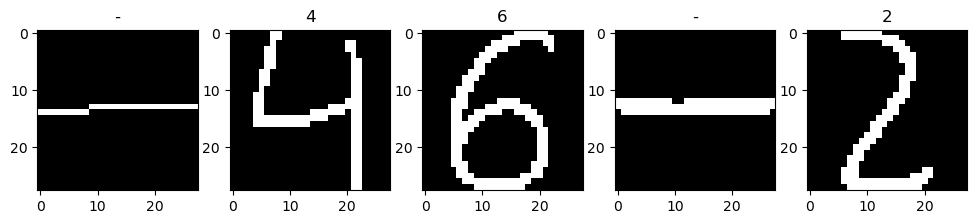

In [8]:
categories = []
res_string = ''

print("-----------------PREDICTION STAGE-----------------")

for i in range(n_elements):
    # Classify each image
    category = clasiffication.classify_input_model(data[:, :, i])
    # Insert category in categories array
    categories.append(category)
    prediction = main_vm.category_string_conversion(category)

    # Plotting prediction
    plt.subplot(n_cols_plot, 5, i + 1)
    plt.title(prediction)
    plt.imshow(data[:, :, i], cmap='grey')

    res_string += prediction

# Convert to numpy array
categories = np.array(categories)

# RESULTS
print(f"\nPREDICTION STRING: {res_string} ")
plt.show()

Now we can see that the title of our plotted images are their corresponding symbol, that means the prediction went well.

With this, here comes our next and final part of the pipeline:

# **<span style="color:blue"><b><i>4.- Final operation forming and solving</i></b></span>**

This final part is really challenging because We need to work with everything We have gotten from previous steps in order to create the final operation.

We must not only distinguish between digits and operands, but also their localization in the original image. Moreover, the overriding difficulty We must face is to identify the division operand.

In the previous step results, you may have realized that the **division and substraction symbol correspond to the same category, '-'**. The reason behind this is that They are both, essentially, the same symbol. The only difference is that the division symbol tends to be longer than the substraction symbol, but as We are working with images of a fixed size (28x28), You cannot tell that difference.

![Image](images/notebookImages/img_4.png)

Given that We cannot work with the contour images, We need to go back to the original bounding rects and find a way to distinguish between division and substraction. The solution I have come up with is implemented in the `identify_div()` method (brief explanation):

For each contour that correspond to the category 11 ('-'):

1. Create a list of contours that **sorround the contour vertically (x-axis)**, i.e take all contours that share the `x` coordinate with the symbol at any point. We will call this list as `horizontal_cont_list`.
2. If the list is empty, it means that It is not a division (division must have numerator and denominator).
3. Calculate which is the **closest element** by creating an array computing the absolute distances between the contour and all elements in the `horizontal_cont_list`.
4. Take the minimum element of the array. If the element corresponds to another '-' that means It is not a division, otherwise It is a division.

---

With this method, We have classified the division and substraction. Note that there are many ways of solving this, the one I have used is just one of them.

The step 4 may look complex, but the logic behind It is that the only case where the closest element is a '-' is when the symbol is a substraction, because They cannot have a numerator or denominator. If a substraction symbol does have a number above or below, It means that there must be a division symbol between them. That is why the division symbol would be the closest one. That is the case We find in our image:

![Image](images/notebookImages/img_5.png)

> This section of code is dense so, for more details, feel free to take a look at the full implementation. 


In [9]:
final_expression = main_vm.generate_expression(categories, contours_ordered)
print(f"EXPRESSION: {final_expression}")
try:
    # eval() is a function that Python already implements
    # It returns the solution given a string of an operation
    print(f"RESULT: {eval(final_expression)}")
except Exception:
    print("ERROR: Invalid operation")

EXPRESSION: ((4-2)/(6))
RESULT: 0.3333333333333333


## And... That's it!!

I hope you enjoyed this overview as much as I did creating this project!

Please, note that all the code I have used above can be found on the project files.

Feel free to check out my GitHub : [https://github.com/adriantd3/VisionMath](https://github.com/adriantd3/VisionMath)
